Trying something new

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display

In [2]:
# We define our model states using MIDI for labeling notes
ode15 = [64, 64, 65, 67, 67, 65, 64, 62, 60, 60, 62, 64, 64, 62, 62]
beats = [1]*15
events = list(zip(ode15, beats))

NOTE_NAMES = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

In [3]:
def midi_to_hz(m): return 440.0 * (2.0 ** ((m - 69) / 12.0))

def hz_to_cqt_bin(hz, fmin, bins_per_octave):
    return int(np.round(bins_per_octave * np.log2(hz / fmin)))

def expected_cqt_bins_for_note(midi, fmin=librosa.note_to_hz("C2"), bins_per_octave=12):
    f0 = midi_to_hz(midi)
    return [hz_to_cqt_bin(f0, fmin, bins_per_octave)]

def midi_to_name(m):
    return f"{NOTE_NAMES[m % 12]}{(m // 12) - 1}"

def print_hmm_model(states, A, dt_ms):
    print("=== HMM Model ===")
    print(f"Number of states: {len(states)}")
    print()

    for i, s in enumerate(states):
        note = midi_to_name(s["pitch"])
        dur_frames = s["dur_steps"]
        dur_ms = dur_frames * dt_ms
        
        stay_prob = A[i, i]
        adv_prob = A[i, i+1] if i < len(states)-1 else 0.0

        print(f"State {i}: {note}")
        print(f"  Expected duration: {dur_frames} frames (~{dur_ms:.1f} ms)")
        print(f"  Transition: stay={stay_prob:.4f}, advance={adv_prob:.4f}")
        print()

def mp3_to_cqt_db(audio_path, sr=22050, hop_length=512,
                  fmin=librosa.note_to_hz("C2"), n_bins=84, bins_per_octave=12):
    y, sr_used = librosa.load(audio_path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=35)

    C = librosa.cqt(y=y, sr=sr_used, hop_length=hop_length,
                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)
    C_mag = np.abs(C)
    X_db = librosa.amplitude_to_db(C_mag, ref=np.max)     # (n_bins, T)
    return X_db, y, sr_used

def dt_ms_from_cqt(sr, hop_length):
    return (hop_length / sr) * 1000.0

def build_hmm_from_beats(pitches, beats, bpm_ref, dt_ms):
    assert len(pitches) == len(beats)
    ms_per_beat = 60000.0 / bpm_ref
    frames_per_beat = ms_per_beat / dt_ms

    states = []
    for idx, (pitch, dur) in enumerate(zip(pitches, beats)):
        dur_steps = max(1, int(round(dur * frames_per_beat)))
        states.append({"idx": idx, "pitch": pitch, "beats": dur, "dur_steps": dur_steps})

    N = len(states)
    A = np.zeros((N, N), float)

    for i, s in enumerate(states):
        if i == N - 1:
            A[i, i] = 1.0
        else:
            p_adv = 1.0 / s["dur_steps"]
            A[i, i] = 1.0 - p_adv
            A[i, i+1] = p_adv

    pi = np.zeros(N); pi[0] = 1.0
    return states, A, pi

In [4]:
bpm_ref = 120
sr = 22050
hop_length = 512
dt_ms = dt_ms_from_cqt(sr, hop_length)

states, A, pi = build_hmm_from_beats(ode15, beats, bpm_ref, dt_ms)
print_hmm_model(states, A, dt_ms)

=== HMM Model ===
Number of states: 15

State 0: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 1: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 2: F4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 3: G4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 4: G4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 5: F4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 6: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 7: D4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 8: C4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 9: C4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.95

In [5]:
def extract_features(audio_path, sr=22050, hop_length=512):
    y, sr_used = librosa.load(audio_path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=35)

    # onset envelope (frame-based)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr_used, hop_length=hop_length)
    onset_env = (onset_env - onset_env.min()) / (onset_env.max() - onset_env.min() + 1e-9)

    # harmonic for pitch features (optional but helps)
    y_harm, _ = librosa.effects.hpss(y)

    # chroma is simplest for pitch scoring
    chroma = librosa.feature.chroma_cqt(y=y_harm, sr=sr_used, hop_length=hop_length)  # (12,T)
    chroma = chroma / (np.linalg.norm(chroma, axis=0, keepdims=True) + 1e-9)

    T = chroma.shape[1]
    onset_env = onset_env[:T]  # align

    return y, sr_used, onset_env, chroma

def candidate_boundaries_from_onsets(onset_env, sr, hop_length,
                                     min_sep_s=0.12, pre_max=3, post_max=3, delta=0.08):
    """
    Returns candidate boundary frames (sorted).
    """
    # librosa peak picker works well for onset envelope
    peaks = librosa.util.peak_pick(onset_env,
                                  pre_max=pre_max, post_max=post_max,
                                  pre_avg=pre_max, post_avg=post_max,
                                  delta=delta,
                                  wait=int((min_sep_s * sr) / hop_length))
    return np.array(peaks, dtype=int)

In [6]:
y, sr, onset_env, chroma = extract_features("goodpitch.mp3", sr=22050, hop_length=512)
peaks = candidate_boundaries_from_onsets(onset_env, sr, hop_length=512)
peaks[:20], len(peaks)

(array([  3,  33,  65, 102, 132, 161, 190, 221, 254, 284, 322, 356, 383,
        431, 454]),
 15)

In [7]:
def filter_peaks_near_edges(peaks, T, min_start_frames=6, min_end_frames=6):
    """
    Remove candidate peaks too close to the start/end.
    """
    peaks = np.asarray(peaks, dtype=int)
    return peaks[(peaks >= min_start_frames) & (peaks <= T - min_end_frames)]

def choose_top_k_boundaries(onset_env, peaks, k, min_start_frames=6, min_end_frames=6):
    T = len(onset_env)
    peaks = filter_peaks_near_edges(peaks, T, min_start_frames, min_end_frames)

    if len(peaks) == 0:
        return np.array([], dtype=int)

    if len(peaks) <= k:
        return np.sort(peaks)

    idx = np.argsort(onset_env[peaks])[-k:]   # strongest k peaks
    return np.sort(peaks[idx])

def boundaries_to_segments(boundaries, T):
    """
    boundaries: sorted frame indices where a new note begins (excluding 0)
    returns list of (start_frame, end_frame)
    """
    b = np.unique(np.clip(boundaries, 1, T-1))
    starts = np.r_[0, b]
    ends = np.r_[b, T]
    return list(zip(starts, ends))

In [8]:
T = chroma.shape[1]
boundaries = choose_top_k_boundaries(onset_env, peaks, k=14)
segments = boundaries_to_segments(boundaries, T)
len(segments), boundaries[:10]

(15, array([ 33,  65, 102, 132, 161, 190, 221, 254, 284, 322]))

In [9]:
def plot_onset_with_boundaries(onset_env, boundaries, sr, hop_length, title="Onset strength + chosen boundaries"):
    """
    onset_env: (T,) normalized onset strength in [0,1]
    boundaries: array/list of boundary frames (where a new note starts), excluding 0
    """
    T = len(onset_env)
    times = np.arange(T) * hop_length / sr

    plt.figure(figsize=(14, 3))
    plt.plot(times, onset_env, linewidth=2)
    for fr in boundaries:
        plt.axvline(fr * hop_length / sr, linewidth=1)
    plt.ylim(0, 1.05)
    plt.xlabel("Time (s)")
    plt.ylabel("Onset strength")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_cqt_with_boundaries(X_db, boundaries, sr, hop_length, title="CQT with boundaries"):
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(X_db, x_axis="time", y_axis="cqt_hz", sr=sr, hop_length=hop_length)
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")

    for fr in boundaries:
        plt.axvline(fr * hop_length / sr, linewidth=1)

    plt.tight_layout()
    plt.show()

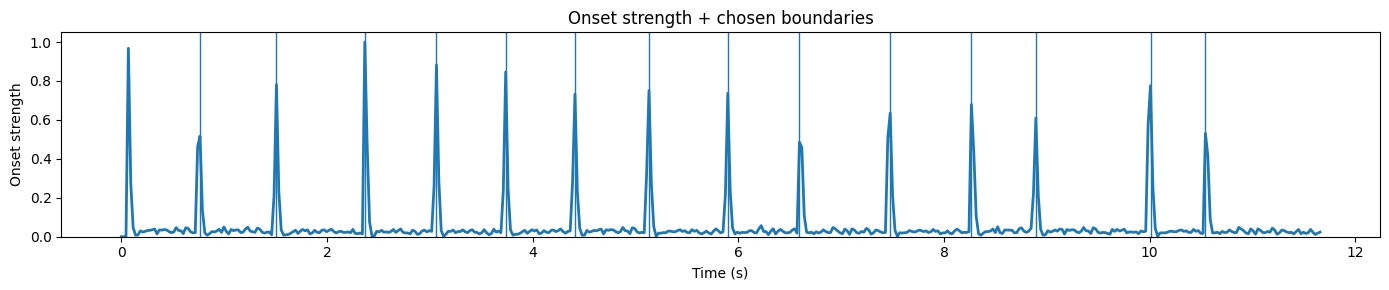

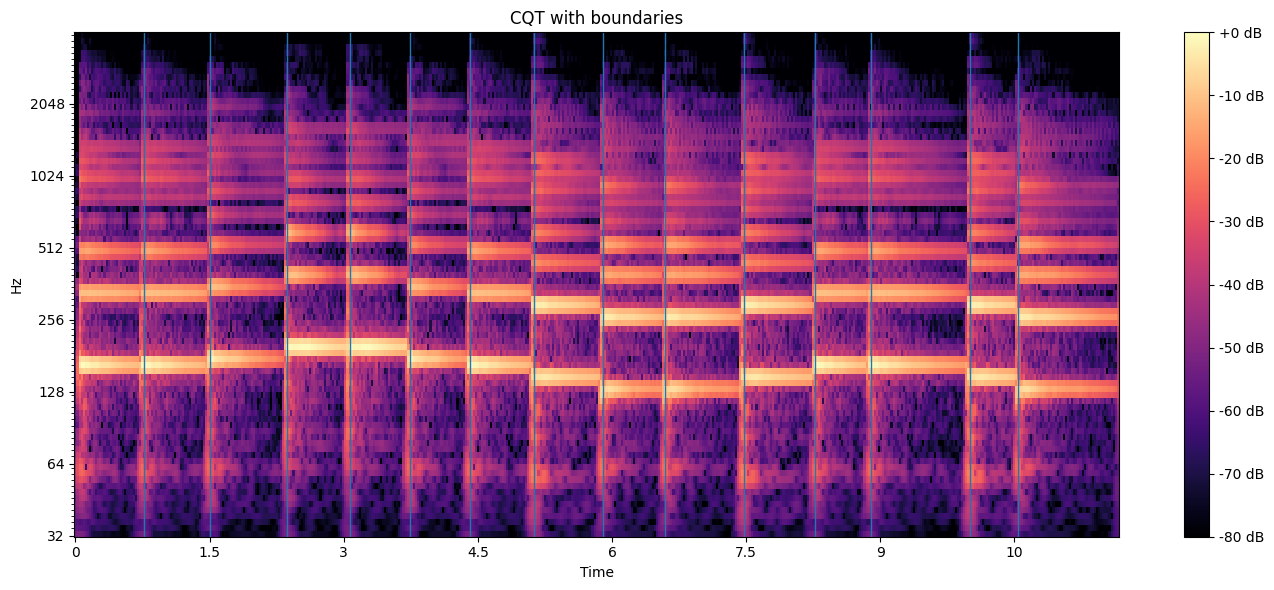

In [15]:
plot_onset_with_boundaries(onset_env, boundaries, sr, hop_length=512)
# mp3_to_cqt_db returns (X_db, y, sr).
# Convert the dB CQT back to amplitude before pitch scoring so we operate on linear magnitudes,
# otherwise most bins are negative dB (ref max -> 0) and get clipped to 0 by np.maximum,
# which yields zero scores.
C_db, y_loaded, sr_used = mp3_to_cqt_db("goodpitch.mp3", sr=22050, hop_length=512)
C = librosa.db_to_amplitude(C_db)

# Use the dB version for visualization but the linear amplitude version for scoring
plot_cqt_with_boundaries(C_db, boundaries, sr, hop_length=512)

In [34]:
def tempo_score_segments(segments, exp_durs):
    obs = np.array([b-a for (a,b) in segments], float)
    exp = np.array(exp_durs, float)
    ratio = obs / np.maximum(exp, 1.0)   # >1 slower, <1 faster

    # Convert to a bounded score: 1 is perfect, drops as ratio deviates
    # This is symmetric: ratio and 1/ratio penalized similarly.
    err = np.abs(np.log(np.maximum(ratio, 1e-9)))
    score = np.exp(-err)  # in (0,1], 1 = perfect
    return score, ratio

In [17]:
def cqt_pitch_template(midi, n_bins, fmin, bins_per_octave=12, window=1, harmonics=(1,2,3,4), harm_weights=(1.0, 0.6, 0.4, 0.25)):
    tpl = np.zeros(n_bins, dtype=float)
    f0 = midi_to_hz(midi)

    for h, w in zip(harmonics, harm_weights):
        k = hz_to_cqt_bin(h * f0, fmin, bins_per_octave)
        for kk in range(k - window, k + window + 1):
            if 0 <= kk < n_bins:
                tpl[kk] += w

    tpl /= (np.linalg.norm(tpl) + 1e-9)
    return tpl

In [18]:
def cosine_similarity(a, b, eps=1e-8):
    return float(np.dot(a, b) / ((np.linalg.norm(a) * np.linalg.norm(b)) + eps))

def keep_topk_bins(col, K=15):
    out = np.zeros_like(col)
    idx = np.argpartition(col, -K)[-K:]
    out[idx] = col[idx]
    return out

def segment_avg(C, a, b):
    """Average spectrum over frames [a,b) -> 1D vector (n_bins,)"""
    v = C[:, a:b].mean(axis=1)
    v = np.maximum(v, 0.0)
    return v

def pitch_score_segment_expected(C_prac, seg, expected_bin_idxs, harmonic_offsets=(0,12,19,24), window=1, eps=1e-8):
    a, b = seg

    # average spectrum of this segment
    v = C_prac[:, a:b].mean(axis=1)
    v = np.maximum(v, 0.0)

    mask = np.zeros_like(v, dtype=bool)

    for idx in expected_bin_idxs:
        for off in harmonic_offsets:
            ii = idx + off
            if 0 <= ii < v.shape[0]:
                lo = max(0, ii - window)
                hi = min(v.shape[0], ii + window + 1)
                mask[lo:hi] = True

    total_energy = v.sum() + eps
    return float(v[mask].sum() / total_energy)

In [35]:
pitch_scores = []

for i, seg in enumerate(segments[:len(ode15)]):
    midi = ode15[i]
    bins = expected_cqt_bins_for_note(midi)

    score = pitch_score_segment_expected(
        C,
        seg,
        bins,
        harmonic_offsets=(0,12,19,24),
        window=1
    )
    pitch_scores.append(score)

pitch_scores = np.array(pitch_scores)
pitch_percent = pitch_scores.mean() * 100.0

print("Segment pitch scores:", pitch_scores)
print("Overall pitch accuracy: %.2f%%" % pitch_percent)

Segment pitch scores: [0.79387337 0.81426281 0.76556784 0.83093256 0.82437122 0.77086228
 0.77446324 0.77120924 0.82116574 0.78014833 0.80158156 0.80550253
 0.79018933 0.77667105 0.2515505 ]
Overall pitch accuracy: 75.82%


In [36]:
def plot_cqt_with_colored_segments(X_db, segments, pitch_scores, sr, hop_length,
                                   title="CQT with colored segments (pitch score)",
                                   alpha=0.22, vmin=0.0, vmax=1.0):
    """
    X_db: (n_bins, T) CQT in dB
    segments: list of (start_frame, end_frame)
    pitch_scores: array/list length >= len(segments), values ideally in [0,1]
    """
    S = min(len(segments), len(pitch_scores))
    scores = np.asarray(pitch_scores[:S], dtype=float)

    # If your scores are not in [0,1], normalize them
    if (scores.min() < 0.0) or (scores.max() > 1.0):
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(figsize=(14, 6))

    img = librosa.display.specshow(
        X_db,
        x_axis="time",
        y_axis="cqt_hz",
        sr=sr,
        hop_length=hop_length,
        cmap="gray"
    )
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")  # CQT dB colorbar (this one works)

    # segment shading
    for i in range(S):
        a, b = segments[i]
        t0 = a * hop_length / sr
        t1 = b * hop_length / sr
        ax.axvspan(t0, t1, color=cmap(norm(scores[i])), alpha=alpha, linewidth=0)

    # boundary lines
    for i in range(1, S):
        t = segments[i][0] * hop_length / sr
        ax.axvline(t, color="k", linewidth=0.8, alpha=0.55)

    # pitch-score colorbar (attach to ax explicitly)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, pad=0.01, label="Pitch score (0–1)")

    fig.tight_layout()
    plt.show()

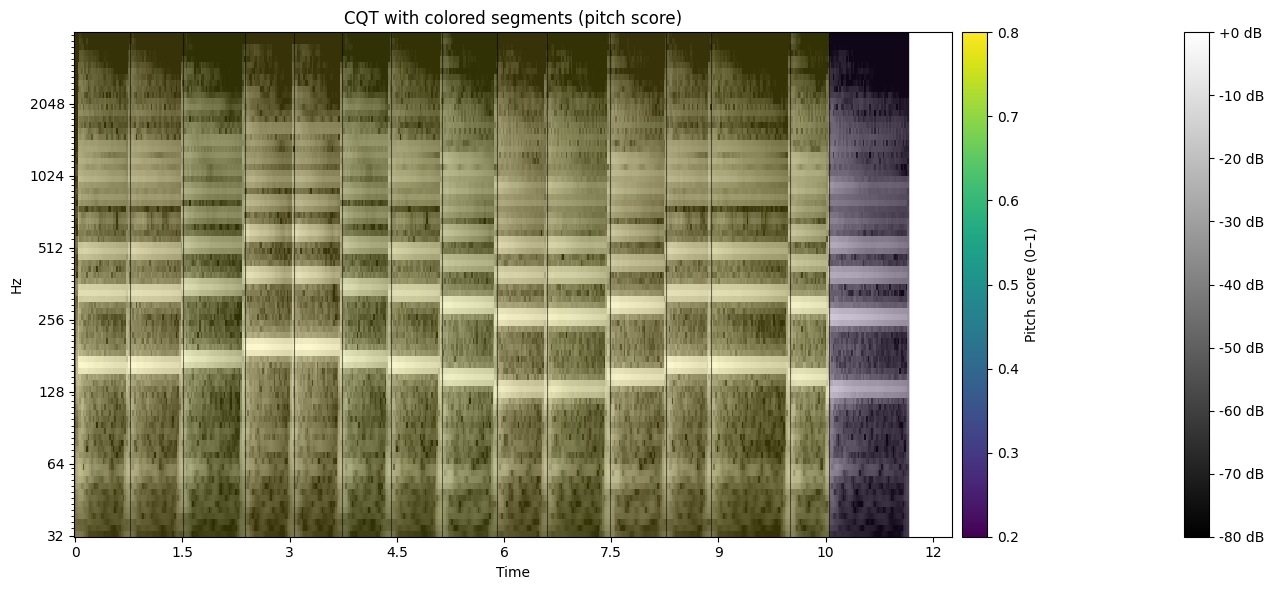

In [37]:
plot_cqt_with_colored_segments(C_db, segments, pitch_scores, sr, hop_length=512, vmin=0.2, vmax=0.8)

In [39]:
def segments_table(segments, ode15, exp_durs, sr, hop_length, chroma):
    tempo_scores, ratios = tempo_score_segments(segments, exp_durs)

    rows = []
    for i, (a,b) in enumerate(segments):
        t0 = a * hop_length / sr
        t1 = b * hop_length / sr
        rows.append({
            "i": i,
            "note": midi_to_name(ode15[i]),
            "start_s": t0,
            "end_s": t1,
            "dur_frames": b-a,
            "exp_frames": exp_durs[i],
            "tempo_ratio": ratios[i],
            "tempo_score": tempo_scores[i],
            "pitch_score": pitch_scores[i],
        })
    return pd.DataFrame(rows)

table = segments_table(segments, ode15, [s["dur_steps"] for s in states], sr, hop_length, chroma)
table

,i,note,start_s,end_s,dur_frames,exp_frames,tempo_ratio,tempo_score,pitch_score
0,0,E4,0.000000,0.766259,33,22,1.500000,0.666667,0.793873
1,1,E4,0.766259,1.509297,32,22,1.454545,0.687500,0.814263
2,2,F4,1.509297,2.368435,37,22,1.681818,0.594595,0.765568
3,3,G4,2.368435,3.065034,30,22,1.363636,0.733333,0.830933
4,4,G4,3.065034,3.738413,29,22,1.318182,0.758621,0.824371
5,5,F4,3.738413,4.411791,29,22,1.318182,0.758621,0.770862
6,6,E4,4.411791,5.131610,31,22,1.409091,0.709677,0.774463
7,7,D4,5.131610,5.897868,33,22,1.500000,0.666667,0.771209
8,8,C4,5.897868,6.594467,30,22,1.363636,0.733333,0.821166
9,9,C4,6.594467,7.476825,38,22,1.727273,0.578947,0.780148
